# Discussion 3 – Classification Workflows with Logistic Regression

## Welcome 👋

In this notebook, you will:

- Build intuition for **logistic regression** using small synthetic datasets
- Understand **classification errors** and evaluation metrics
- Use **ROC curves** and **AUC** to compare classifiers
- Apply the full workflow to the **South German Credit** dataset

We will first study each concept in isolation using simple, synthetic data. Then, we will combine everything into a complete real-world workflow, which will help a lot for **Assignment 2**!

## Learning Goals

By the end of this discussion, you will be able to:

1. Implement logistic regression using **sklearn**
3. Understand classification errors through **confusion matrices**
4. Evaluate classifiers using **ROC** and **AUC**
5. Apply a full classification **workflow** to real credit data

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, roc_curve, auc, log_loss, roc_auc_score, accuracy_score, RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

random_seed = 42
np.random.seed(random_seed)

## Concept 1: Logistic Regression as a Probability Model



Suppose we observe a single feature $x$ and a binary outcome $y$:

- $x$: hours studied
- $y = 1$: pass
- $y = 0$: fail

We want to model the probability of passing as a function of hours studied.

Logistic regression models:

$$
P(y = 1 \mid x) = \sigma(w_0 + w_1 x)
$$

where:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

As $x$ increases:
- $w_0 + w_1 x$ increases
- the sigmoid output moves smoothly from 0 to 1
- predictions can be interpreted as probabilities

### Why Not Linear Regression?

If we used linear regression here, predictions could be:[-inf, inf]

Logistic regression avoids this by constraining predictions to $[0,1]$.

## Concept 2: Logistic Loss

Suppose a student actually **passed**, so the true label is:

$$
y = 1
$$

The logistic loss for a single observation is:

$$
\ell(y, \hat{p})
= - \left[ y \log(\hat{p}) + (1 - y)\log(1 - \hat{p}) \right]
$$

Because $y = 1$, this simplifies to:

$$
\ell(1, \hat{p}) = -\log(\hat{p})
$$


Suppose the model predicts:

$$
\hat{p} = 0.9
$$

The loss is:

$$
\ell(1, 0.9) = -\log(0.9) \approx 0.105
$$

Now suppose the model predicts:

$$
\hat{p} = 0.1
$$

Then the loss is:

$$
\ell(1, 0.1) = -\log(0.1) \approx 2.303
$$

This loss is **more than 20× larger** than in the previous case.


## Concept 3: Gradient Descent

Consider a toy dataset with one feature:

- $x = [1, 2, 3]$
- $y = [0, 0, 1]$

Suppose the model initially predicts high probabilities for all points.

Gradient descent works by:
1. Computing predicted probabilities
2. Measuring how wrong those predictions are
3. Updating parameters to reduce future errors

If the model predicts a high probability for $y=0$ points, the gradient pushes parameters to lower those probabilities. Iteration by iteration, the decision boundary shifts until predicted probabilities align with observed labels.

## Concept 4: From Probabilities to Class Predictions

Suppose a model predicts probabilities:

| Observation | $\hat{p}$ |
|-------------|-----------|
| A           | 0.90      |
| B           | 0.60      |
| C           | 0.40      |
| D           | 0.10      |

With threshold $\tau = 0.5$:
- A, B → class 1
- C, D → class 0

With threshold $\tau = 0.7$:
- A → class 1
- B, C, D → class 0

Changing the threshold changes **who gets classified as positive**.


## Concept 5: Confusion Matrix and Errors

### The Confusion Matrix

For a binary classifier, predictions can be summarized in a **confusion matrix**.

|                    | Predicted Positive | Predicted Negative |
|--------------------|-------------------|-------------------|
| **Actual Positive** | True Positive (TP) | False Negative (FN) |
| **Actual Negative** | False Positive (FP) | True Negative (TN) |

In words:
- **TP**: correctly predict positive
- **FP**: predict positive when the true label is negative
- **TN**: correctly predict negative
- **FN**: predict negative when the true label is positive


### Error Metrics Derived from the Confusion Matrix

From these four quantities, we can define common evaluation metrics.

**True Positive Rate (TPR)**, also called *recall* or *sensitivity*:

$$
\text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$

This answers:
> Of all actual positives, how many did we correctly identify?

**False Positive Rate (FPR)**:

$$
\text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
$$

This answers:
> Of all actual negatives, how many did we incorrectly label as positive?

**Accuracy**:

$$
\text{Accuracy} = \frac{\text{TP} + \text{TN}}
{\text{TP} + \text{FP} + \text{TN} + \text{FN}}
$$

This answers:
> What fraction of predictions were correct?


### Why These Metrics Can Be Misleading?

At first glance, metrics like accuracy, TPR, and FPR seem reasonable. However, they can be **deeply misleading** when the data are imbalanced.

Suppose we are predicting rare events:

- 1000 observations total
- 950 negatives
- 50 positives (only 5% positive class)

Consider a trivial classifier that **always predicts negative**, then:

|                    | Predicted Positive | Predicted Negative |
|--------------------|-------------------|-------------------|
| **Actual Positive** | TP = 0             | FN = 50            |
| **Actual Negative** | FP = 0             | TN = 950           |


**Accuracy**

$$
\text{Accuracy}
= \frac{\text{TP} + \text{TN}}{\text{TP} + \text{FP} + \text{TN} + \text{FN}}
= \frac{950}{1000}
= 95\%
$$


**True Positive Rate (TPR)**

$$
\text{TPR}
= \frac{\text{TP}}{\text{TP} + \text{FN}}
= \frac{0}{50}
= 0
$$

**False Positive Rate (FPR)**

$$
\text{FPR}
= \frac{\text{FP}}{\text{FP} + \text{TN}}
= \frac{0}{950}
= 0
$$

At first glance, the model might appear to perform well **(high accuracy, low FPR)**. But in reality, it's **HORRIBLE**, useless in detecting the thing we care about.

### Class Imbalance and Threshold Dependence

This example highlights two major issues:

1. **Class imbalance**: When one class dominates, accuracy can be high even for bad models

2. **Threshold dependence**: TP, FP, TN, FN all depend on a chosen decision threshold

ROC curves solve these problems by evaluating classifier performance **across all possible thresholds**.

## Concept 6: ROC and AUC

**Key components:**
- **X-axis**: False Positive Rate (FPR) = FP / (FP + TN) = 1 - Specificity
- **Y-axis**: True Positive Rate (TPR) = TP / (TP + FN) = Sensitivity = Recall

**Why is this useful?**
- Shows the **trade-off** between catching more positives (TPR) and accepting more false alarms (FPR)
- Evaluates performance across **all** thresholds, not just one

**To build an ROC curve:**
1. Vary the decision threshold from 1 to 0
2. Compute a confusion matrix at each threshold
3. Calculate TPR and FPR from each confusion matrix
4. Plot TPR vs FPR

Sample predicted probabilities: [0.01846125 0.96641434 0.37001939 0.10940051 0.99002047 0.82166233
 0.48902177 0.05954211 0.88742091 0.57725236]
Corresponding true labels:    [0 1 1 0 1 1 1 0 1 0]
 Threshold      TPR    FPR  TP  FP  TN  FN
       0.9 0.400000 0.0250  56   4 156  84
       0.7 0.700000 0.1000  98  16 144  42
       0.5 0.828571 0.1875 116  30 130  24
       0.3 0.957143 0.3500 134  56 104   6
       0.1 0.992857 0.5750 139  92  68   1


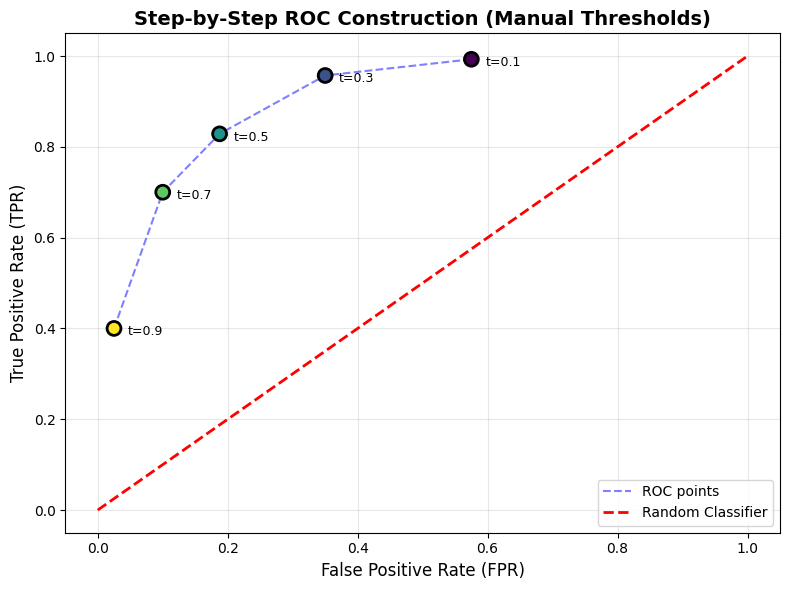

In [2]:
# -------------------------
# Step 0: Setup and train model
# -------------------------
np.random.seed(42)

X, y = make_classification(
    n_samples=1000, n_features=20, n_informative=15, 
    n_redundant=5, n_classes=2, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

y_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print("Sample predicted probabilities:", y_proba[:10])
print("Corresponding true labels:   ", y_test[:10])

# -------------------------
# Step 1: Define thresholds and compute TPR/FPR
# -------------------------
thresholds = [0.9, 0.7, 0.5, 0.3, 0.1]

tpr_list = []
fpr_list = []
results_data = []

for threshold in thresholds:
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    tpr_list.append(tpr)
    fpr_list.append(fpr)
    
    results_data.append({
        'Threshold': threshold,
        'TPR': tpr,
        'FPR': fpr,
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn
    })

df_results = pd.DataFrame(results_data)
print(df_results.to_string(index=False))

# -------------------------
# Step 2: Plot ROC points
# -------------------------
plt.figure(figsize=(8, 6))
plt.scatter(fpr_list, tpr_list, s=100, c=thresholds, cmap='viridis', 
            edgecolors='black', linewidths=2, zorder=3)
plt.plot(fpr_list, tpr_list, 'b--', alpha=0.5, label='ROC points')
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier', linewidth=2)

for i, threshold in enumerate(thresholds):
    plt.annotate(f't={threshold}', (fpr_list[i], tpr_list[i]), 
                 xytext=(10, -5), textcoords='offset points', fontsize=9)

plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('Step-by-Step ROC Construction (Manual Thresholds)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


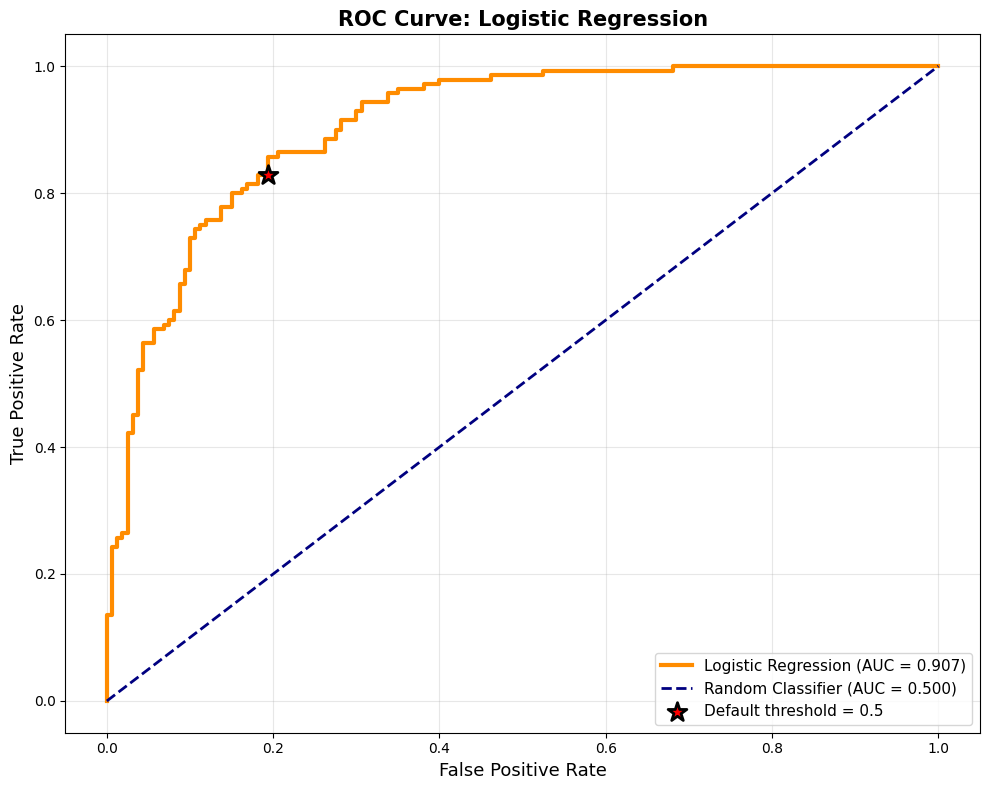

In [3]:
# -------------------------
# ROC and AUC Pipeline
# -------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=3, 
         label=f'Logistic Regression (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier (AUC = 0.500)')

default_idx = np.argmin(np.abs(thresholds - 0.5))
plt.scatter(fpr[default_idx], tpr[default_idx], s=200, c='red', 
            marker='*', edgecolors='black', linewidths=2, zorder=5,
            label=f'Default threshold = 0.5')

plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('ROC Curve: Logistic Regression', fontsize=15, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The ROC curve visualizes the **trade-off** between TPR and FPR across all thresholds. Each point represents a threshold choice, showing how being more conservative or aggressive affects predictions.

- The **default threshold (0.5)** is often a balanced starting point.  
- For **high-risk applications** where missing positives is costly (e.g., fraud detection), we can **lower the threshold** to increase TPR, accepting more false positives.  
- For **cost-sensitive scenarios** where false positives are costly (e.g., sending notifications), we can **raise the threshold** to reduce FPR.  

A common heuristic is to **choose the point closest to the upper-left corner**, which maximizes TPR while minimizing FPR. The ROC curve helps **visually identify this optimal trade-off** based on context and business priorities.

Models ranked by AUC:
1. Random Forest             AUC = 0.9647
2. Logistic Regression       AUC = 0.9071
3. Naive Bayes               AUC = 0.8872
4. Decision Tree (depth=5)   AUC = 0.7857
5. Weak Tree (depth=1)       AUC = 0.6813


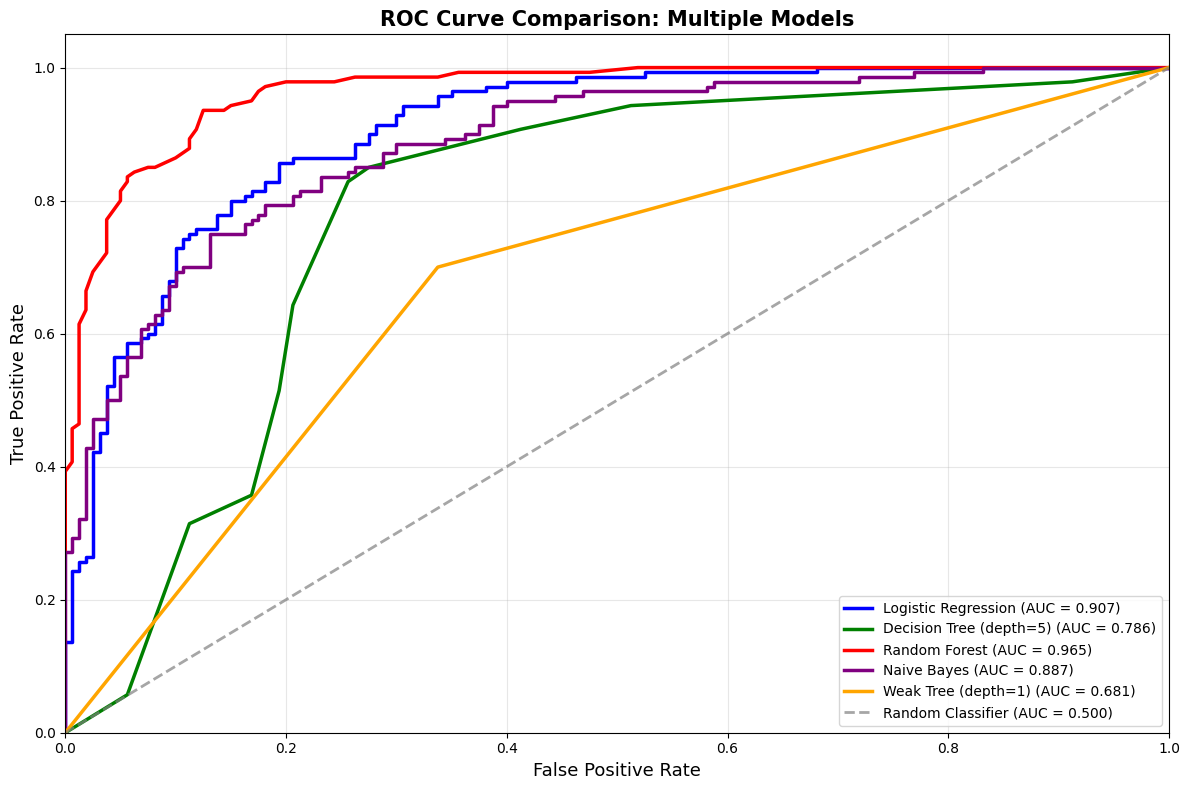

In [4]:
# -------------------------
# Step 0: Define and train multiple models
# -------------------------
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree (depth=5)': DecisionTreeClassifier(random_state=42, max_depth=5),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Naive Bayes': GaussianNB(),
    'Weak Tree (depth=1)': DecisionTreeClassifier(random_state=42, max_depth=1)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_proba = model.decision_function(X_test_scaled)
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    results[name] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}

# -------------------------
# Step 1: Rank models by AUC
# -------------------------
ranked_models = sorted(results.items(), key=lambda x: x[1]['auc'], reverse=True)

print("Models ranked by AUC:")
for i, (name, result) in enumerate(ranked_models, 1):
    print(f"{i}. {name:<25s} AUC = {result['auc']:.4f}")

# -------------------------
# Step 2: Plot ROC curves for all models
# -------------------------
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red', 'purple', 'orange']

for (name, result), color in zip(results.items(), colors):
    plt.plot(result['fpr'], result['tpr'], lw=2.5, color=color,
             label=f"{name} (AUC = {result['auc']:.3f})")

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', 
         label='Random Classifier (AUC = 0.500)', alpha=0.7)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('ROC Curve Comparison: Multiple Models', fontsize=15, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The Area Under the ROC Curve (AUC) provides a single-number summary of a model’s ability to balance TPR and FPR across all thresholds. By plotting multiple models on the same graph, we can compare their overall classification performance.

- Models with curves that **bow closer to the upper-left corner** have higher AUC, meaning they generally achieve higher TPR for lower FPR.  
- The **Weak Tree (depth=1)** has a curve close to the diagonal and low AUC, indicating poor classification ability.  
- **Random Forest** typically has the highest AUC due to its ensemble structure, producing a curve that stays high and to the left.  
- All models are above the diagonal line, meaning they perform better than random guessing.

A larger AUC generally indicates **better average performance across all thresholds**, but it does **not guarantee the model is absolutely better** in every scenario:

1. **Context matters:** Some applications prioritize **high recall** (e.g., detecting fraud) or **low false positives** (e.g., costly notifications). A model with slightly lower AUC might be preferred if it performs better in the relevant threshold region.  
2. **Threshold-specific trade-offs:** AUC averages over all thresholds, but in practice we use a **specific threshold**. Two models with similar AUC could behave very differently at the threshold we actually choose.  
3. **Other factors:** Simplicity, interpretability, training time, and robustness might make a model with lower AUC more suitable in certain contexts.

**Practical takeaway:** Use AUC to **screen and rank models**, but combine it with **threshold analysis and domain priorities** to select the best model for your specific problem.


## Real Data Example: South German Credit

Each row represents one applicant, and the target variable indicates whether the applicant was a **good credit risk** (y = 1)or a **bad credit risk** (y = 0). Our goal is to **predict the probability that an applicant is a good credit risk**, based on their observed characteristics.

## Part 1: Data Exploration and Preprocessing

In [5]:
# variable names from UCI documentation
colnames = [
    "status",                 # laufkont
    "duration",               # laufzeit
    "credit_history",         # moral
    "purpose",                # verw
    "amount",                 # hoehe
    "savings",                # sparkont
    "employment_duration",    # beszeit
    "installment_rate",       # rate
    "personal_status_sex",    # famges
    "other_debtors",          # buerge
    "present_residence",      # wohnzeit
    "property",               # verm
    "age",                    # alter
    "other_installment_plans",# weitkred
    "housing",                # wohn
    "number_credits",         # bishkred
    "job",                    # beruf
    "people_liable",          # pers
    "telephone",              # telef
    "foreign_worker",         # gastarb
    "credit_risk"             # kredit
]

df = pd.read_csv(
    "SouthGermanCredit.asc",
    sep=r"\s+",
    names=colnames,
    engine="python",
    header=0
)

y = df["credit_risk"]
X = df.drop(columns="credit_risk")

In [6]:
# number of observations and predictors
print("Number of observations:", X.shape[0])
print("Number of predictors:", X.shape[1])

Number of observations: 1000
Number of predictors: 20


In [8]:
# use documentation to identify categorical versus numeric features
# https://archive.ics.uci.edu/dataset/522/south+german+credit
categorical_features = [
    "status",
    "credit_history",
    "purpose",
    "savings",
    "personal_status_sex",
    "other_debtors",
    "other_installment_plans",
    "housing"
]

numeric_features = [
    "duration",
    "amount",
    "employment_duration",
    "installment_rate",
    "present_residence",
    "property",
    "age",
    "number_credits",
    "job",
    "people_liable",
    "telephone",
    "foreign_worker"
]

print("Categorical predictors:", categorical_features)

print("\nNumeric predictors:", numeric_features)

Categorical predictors: ['status', 'credit_history', 'purpose', 'savings', 'personal_status_sex', 'other_debtors', 'other_installment_plans', 'housing']

Numeric predictors: ['duration', 'amount', 'employment_duration', 'installment_rate', 'present_residence', 'property', 'age', 'number_credits', 'job', 'people_liable', 'telephone', 'foreign_worker']


In [9]:
# check for missing values
print("Missing values by column:")
print(df.isna().sum())

Missing values by column:
status                     0
duration                   0
credit_history             0
purpose                    0
amount                     0
savings                    0
employment_duration        0
installment_rate           0
personal_status_sex        0
other_debtors              0
present_residence          0
property                   0
age                        0
other_installment_plans    0
housing                    0
number_credits             0
job                        0
people_liable              0
telephone                  0
foreign_worker             0
credit_risk                0
dtype: int64


In [10]:
# one hot encoding for categorical
# naive way of handeling missing values: numeric -> median; categorical -> mode
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [11]:
# proportion of positive outcome
p_y_1 = np.mean(y == 1)
print("Pr(y = 1):", p_y_1)

Pr(y = 1): 0.7


## Part 2: Train, Validation, and Test Splits

In [14]:
# split train test with stratification
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.4,
    stratify=y,
    random_state=random_seed
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=random_seed
)

print("Pr(y = 1) in training set:", np.mean(y_train))
print("Pr(y = 1) in validation set:", np.mean(y_val))
print("Pr(y = 1) in test set:", np.mean(y_test))

Pr(y = 1) in training set: 0.7
Pr(y = 1) in validation set: 0.7
Pr(y = 1) in test set: 0.7


### What happens when you DON'T stratify?

## Part 3: Logistic Regression with scikit-learn

In [17]:
baseline_model = Pipeline(steps=[
    ("preprocess", preprocess),
    # default sklearn is C=1 -> which has regularization strength! 
    ("logreg", LogisticRegression(C=1e10, solver="lbfgs", max_iter=1000, random_state=random_seed))])

C_grid = np.logspace(-3, 3, 7)

val_log_loss = []
val_auc = []

for C in C_grid:
    model = Pipeline(steps=[
        ("preprocess", preprocess),
        ("logreg", LogisticRegression(
            C=C,
            solver="lbfgs",
            max_iter=1000,
            random_state=random_seed
        ))
    ])
    
    model.fit(X_train, y_train)
    
    # predicted probabilities for y = 1
    y_val_prob = model.predict_proba(X_val)[:, 1]
    
    val_log_loss.append(log_loss(y_val, y_val_prob))
    val_auc.append(roc_auc_score(y_val, y_val_prob))

results = pd.DataFrame({
    "C": C_grid,
    "lambda": 1 / C_grid,
    "log_C": np.log10(C_grid),
    "val_log_loss": val_log_loss,
    "val_auc": val_auc
})

results

,C,lambda,log_C,val_log_loss,val_auc
0,0.001,1000.000,-3.0,0.594217,0.701310
1,0.010,100.000,-2.0,0.549126,0.750238
2,0.100,10.000,-1.0,0.501609,0.800714
3,1.000,1.000,0.0,0.492297,0.812619
4,10.000,0.100,1.0,0.499249,0.808929
5,100.000,0.010,2.0,0.501651,0.808690
6,1000.000,0.001,3.0,0.501254,0.808810


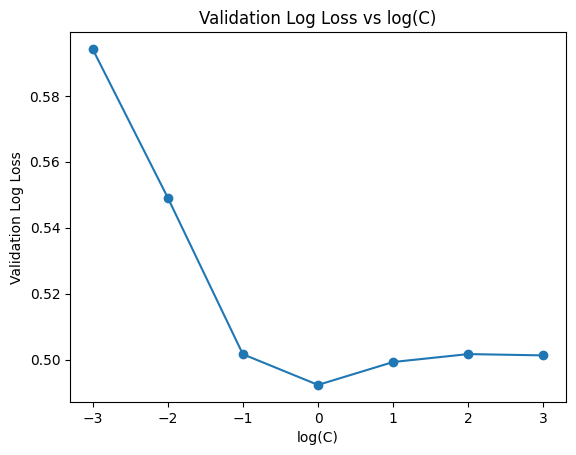

In [18]:
plt.figure()
plt.plot(results["log_C"], results["val_log_loss"], marker="o")
plt.xlabel("log(C)")
plt.ylabel("Validation Log Loss")
plt.title("Validation Log Loss vs log(C)")
plt.show()

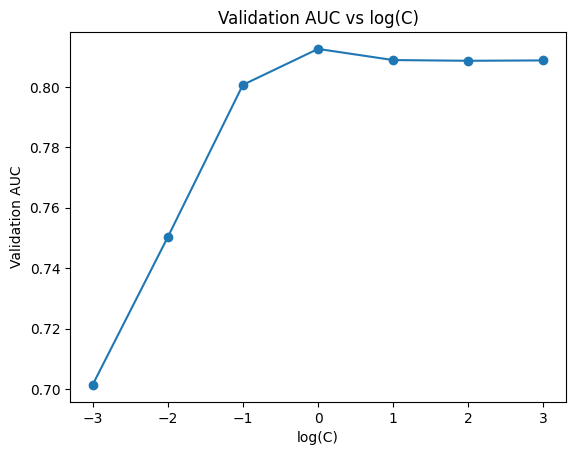

In [19]:
plt.figure()
plt.plot(results["log_C"], results["val_auc"], marker="o")
plt.xlabel("log(C)")
plt.ylabel("Validation AUC")
plt.title("Validation AUC vs log(C)")
plt.show()

In [20]:
best_idx = np.argmin(results["val_log_loss"])
C_star = results.loc[best_idx, "C"]
best_log_loss = results.loc[best_idx, "val_log_loss"]
best_auc = results.loc[best_idx, "val_auc"]

print("Selected C*:", C_star)
print("Validation log loss at C*:", best_log_loss)
print("Validation AUC at C*:", best_auc)

Selected C*: 1.0
Validation log loss at C*: 0.4922971604498706
Validation AUC at C*: 0.8126190476190476


## Part 4: Model Evaluation

In [21]:
# Refit using optimal C* from Part 3
final_model = Pipeline([
    ("preprocess", preprocess),
    ("logreg", LogisticRegression(
        C=C_star,
        solver="lbfgs",
        max_iter=1000,
        random_state=random_seed
    ))
])

# Combine train + validation for final fit
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

final_model.fit(X_trainval, y_trainval)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('logreg', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers con

In [22]:
# predicted probabilities for positive class
y_test_prob = final_model.predict_proba(X_test)[:, 1]

# predicted labels at threshold 0.5
y_test_pred = (y_test_prob >= 0.5).astype(int)

In [25]:
# confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion matrix (threshold=0.5):")
print(cm)

# accuracy
acc = accuracy_score(y_test, y_test_pred)
print("\nAccuracy:", acc)

# AUC
auc = roc_auc_score(y_test, y_test_prob)
print("Test set AUC:", auc)

Confusion matrix (threshold=0.5):
[[ 29  31]
 [ 22 118]]

Accuracy: 0.735
Test set AUC: 0.7935714285714285


`sklearn`'s format:

|                | Predicted 0 | Predicted 1 |
|----------------|------------|------------|
| True 0 (negative) | TN = 29   | FP = 31   |
| True 1 (positive) | FN = 22   | TP = 118  |

**Explanation of the entries:**

- **TN = 29** → correctly predicted negative cases (bad credit predicted as bad)  
- **FP = 31** → predicted positive but actually negative (bad credit predicted as good)  
- **FN = 22** → predicted negative but actually positive (good credit predicted as bad)  
- **TP = 118** → correctly predicted positive cases (good credit predicted as good)  

**Interpretation:**

- The model is **good at identifying positive cases** (TP = 118).  
- There are still a number of **false positives** (FP = 31), which represent bad loans incorrectly predicted as good.  
- Accuracy = (TP + TN) / total = (118 + 29) / (29 + 31 + 22 + 118) = 0.735.  

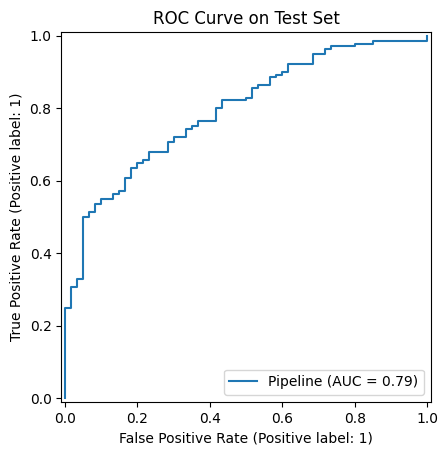

In [26]:
RocCurveDisplay.from_estimator(final_model, X_test, y_test)
plt.title("ROC Curve on Test Set")
plt.show()

## Part 5: Threshold Choice and Economic Interpretation

**Economic scenario: Credit approval decisions**

The bank evaluates credit applications and must decide whether to approve each client. The outcomes are:

| True credit risk | Action | Payoff |
|-----------------|--------|--------|
| Good (y=1)      | Approve | +100 (interest/profit) |
| Bad (y=0)       | Approve | −50 (expected loss + admin) |
| Good (y=1)      | Reject  | −20 (lost potential profit) |
| Bad (y=0)       | Reject  | 0 |

**Justification:**

- Approving a good client generates profit (B > 0).  
- Approving a bad client incurs loss (c > 0).  
- Rejecting a good client has opportunity cost (L ≥ 0).  
- Rejecting a bad client is neutral.  

### Q: Why is the below implementation problemetic? 

In [27]:
y_val_prob = final_model.predict_proba(X_val)[:, 1]

B, c, L = 100, 50, 20
thresholds = np.linspace(0, 1, 101)
expected_payoffs = []

for t in thresholds:
    y_pred = (y_val_prob >= t).astype(int)
    TP = np.sum((y_val == 1) & (y_pred == 1))
    FP = np.sum((y_val == 0) & (y_pred == 1))
    FN = np.sum((y_val == 1) & (y_pred == 0))
    expected_payoffs.append(TP*B - FP*c - FN*L)

best_idx = np.argmax(expected_payoffs)
t_star = thresholds[best_idx]
max_payoff = expected_payoffs[best_idx]

y_test_pred_opt = (final_model.predict_proba(X_test)[:, 1] >= t_star).astype(int)
cm_opt = confusion_matrix(y_test, y_test_pred_opt)
acc_opt = accuracy_score(y_test, y_test_pred_opt)

print("Optimal threshold t*:", t_star)
print("Confusion matrix on test set at t*:\n", cm_opt)
print("Maximum expected payoff on validation set:", max_payoff)
print("Accuracy on test set at t*:", acc_opt)

Optimal threshold t*: 0.44
Confusion matrix on test set at t*:
 [[ 23  37]
 [ 13 127]]
Maximum expected payoff on validation set: 11420
Accuracy on test set at t*: 0.75


### Answer: Fitting and choosing t on validation set is cheating!

The issue is that `final_model` was already **refit on the combined training + validation set**. By using it to compute `y_val_prob` on the validation set, we are effectively **peeking at the validation data** when choosing the threshold `t*`. This introduces **data leakage**, because the threshold is optimized using probabilities from a model that has already “seen” the validation data. 

As a result:  

- The chosen threshold `t*` may appear better than it would on truly unseen data.  
- Test set performance may look optimistic, giving an **overestimation of accuracy or expected payoff**.  

**Best practice:** Use a model trained **only on the training set** when evaluating validation probabilities to select `t*`. Then, after choosing `t*`, you can refit the final model on training + validation for deployment or test evaluation.

### The correct workflow of choosing the optimal threshold

In [28]:
# Step 1: Train a model on training set only using optimal C
model_train_only = Pipeline([
    ("preprocess", preprocess),
    ("logreg", LogisticRegression(
        C=C_star,
        solver="lbfgs",
        max_iter=1000,
        random_state=random_seed
    ))
])

model_train_only.fit(X_train, y_train)

# Step 2: Compute predicted probabilities on validation set
y_val_prob = model_train_only.predict_proba(X_val)[:, 1]

# Step 3: Economic parameters (credit scenario)
B, c, L = 100, 50, 20
thresholds = np.linspace(0, 1, 101)
expected_payoffs = []

for t in thresholds:
    y_pred = (y_val_prob >= t).astype(int)
    TP = np.sum((y_val == 1) & (y_pred == 1))
    FP = np.sum((y_val == 0) & (y_pred == 1))
    FN = np.sum((y_val == 1) & (y_pred == 0))
    expected_payoffs.append(TP*B - FP*c - FN*L)

# Step 4: Choose threshold t* that maximizes expected payoff
best_idx = np.argmax(expected_payoffs)
t_star = thresholds[best_idx]
max_payoff = expected_payoffs[best_idx]

print("Optimal threshold t*:", t_star)
print("Maximum expected payoff on validation set:", max_payoff)

# Step 5: Refit final model on train + validation using optimal C
final_model = Pipeline([
    ("preprocess", preprocess),
    ("logreg", LogisticRegression(
        C=C_star,
        solver="lbfgs",
        max_iter=1000,
        random_state=random_seed
    ))
])
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)
final_model.fit(X_trainval, y_trainval)

# Step 6: Evaluate on test set using t*
y_test_pred_opt = (final_model.predict_proba(X_test)[:, 1] >= t_star).astype(int)
cm_opt = confusion_matrix(y_test, y_test_pred_opt)
acc_opt = accuracy_score(y_test, y_test_pred_opt)

print("Confusion matrix on test set at t*:\n", cm_opt)
print("Accuracy on test set at t*:", acc_opt)

Optimal threshold t*: 0.08
Maximum expected payoff on validation set: 11050
Confusion matrix on test set at t*:
 [[  1  59]
 [  2 138]]
Accuracy on test set at t*: 0.695
